In [1]:
import json
import pandas as pd
import numpy as np
import re

In [2]:
file_dir = 'C://Users/jason.JASON-WIN7/ETL/Movies-ETL'

In [3]:
with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)
# len(wiki_movies_raw)     

In [4]:
# First 5 records
# wiki_movies_raw[:5]
# First 5 records
# wiki_movies_raw[-5:]
# Some records in the middle
# wiki_movies_raw[7059:7061]

In [5]:
kaggle_metadata = pd.read_csv(f'{file_dir}/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}/ratings.csv')

In [6]:
# kaggle_metadata.sample(5)
# ratings.sample(5)

In [7]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)
# wiki_movies_df.head()

In [8]:
# Take a look at the columns. 
# wiki_movies_df.columns.tolist()

In [9]:
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]
len(wiki_movies)

7076

In [10]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    return movie

In [11]:
wiki_movies_df[wiki_movies_df['Arabic'].notnull()]
# wiki_movies_df[wiki_movies_df['Arabic'].notnull()]['url']

,url,year,imdb_link,title,Directed by,Produced by,Screenplay by,Story by,Based on,Starring,...,Predecessor,Founders,Area served,Products,Services,Russian,Hebrew,Revenue,Operating income,Polish
7060,https://en.wikipedia.org/wiki/The_Insult_(film),2018.0,https://www.imdb.com/title/tt7048622/,The Insult,Ziad Doueiri,"[Rachid Bouchareb, Jean Bréhat, Julie Gayet, A...",NaN,NaN,NaN,"[Adel Karam, Kamel El Basha]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7293,https://en.wikipedia.org/wiki/Capernaum_(film),2018.0,https://www.imdb.com/title/tt8267604/,Capernaum,Nadine Labaki,"[Michel Merkt, Khaled Mouzanar]","[Nadine Labaki, Jihad Hojaily, Michelle Keserw...","[Georges Khabbaz, Nadine Labaki, Michelle Kese...",NaN,"[Zain Al Rafeea, Yordanos Shiferaw, Boluwatife...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# sorted(wiki_movies_df.columns.tolist())

In [13]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    # combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune-Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')

    return movie

In [14]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
# wiki_movies_df = pd.DataFrame(clean_movies)
# sorted(wiki_movies_df.columns.tolist())

In [15]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))
# wiki_movies_df.head()

7311
7056


In [16]:
# null values
# [[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]
# Less than 90 percent null values (i.e., populated)
[column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]

['url',
 'year',
 'imdb_link',
 'title',
 'Directed by',
 'Produced by',
 'Screenplay by',
 'Story by',
 'Based on',
 'Starring',
 'Music by',
 'Cinematography',
 'Edited by',
 'Productioncompany ',
 'Distributed by',
 'Release date',
 'Running time',
 'Country',
 'Language',
 'Budget',
 'Box office',
 'Written by',
 'Productioncompanies ',
 'imdb_id']

In [17]:
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]
# wiki_movies_df.head()

In [18]:
# wiki_movies_df.dtypes

In [19]:
box_office = wiki_movies_df['Box office'].dropna()
print(box_office)

0          $21.4 million
1           $2.7 million
2            $57,718,089
3             $7,331,647
4       $6,939,946 (USA)
              ...       
7305       $19.4 million
7306       $41.9 million
7307       $76.1 million
7308       $38.4 million
7309        $5.5 million
Name: Box office, Length: 5484, dtype: object


In [20]:
# Traditional method
# def is_not_a_string(x):
#     return type(x) != str
# box_office[box_office.map(is_not_a_string)]

In [21]:
# Quicker method
# box_office[box_office.map(lambda x: type(x) != str)]
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)
print(box_office)

0          $21.4 million
1           $2.7 million
2            $57,718,089
3             $7,331,647
4       $6,939,946 (USA)
              ...       
7305       $19.4 million
7306       $41.9 million
7307       $76.1 million
7308       $38.4 million
7309        $5.5 million
Name: Box office, Length: 5484, dtype: object


In [22]:
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
box_office.str.contains(form_one, flags=re.IGNORECASE).sum()

3902

In [23]:
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'
box_office.str.contains(form_two, flags=re.IGNORECASE).sum()

1559

In [24]:
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [25]:
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE)
box_office[~matches_form_one & ~matches_form_two]

618                      $5000 (US)
1113                     35,254,617
1541                     £3 million
1952                   ¥1.1 billion
2132                            N/A
2193                           $309
2784    926,423 admissions (France)
3774                            TBA
4026       CN¥3.650 million (China)
4270                     £7,385,434
4476                            $30
4746        $45.2k (only in Turkey)
5645                          £2.56
5983                       413 733$
6222                        Unknown
6587                          $111k
6588                           $588
6813                 less than $372
7070                        8 crore
Name: Box office, dtype: object

In [26]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [27]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [39]:
# wiki_movies_df.head()

In [29]:
budget = wiki_movies_df['Budget'].dropna()

In [30]:
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

In [31]:
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [32]:
print(budget)

0        $20 million
1         $6 million
2        $35 million
3        $12 million
4        $25 million
            ...     
7305    €4.3 million
7306     $42 million
7307     $60 million
7308     $20 million
7309      $9 million
Name: Budget, Length: 4738, dtype: object


In [33]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
budget[~matches_form_one & ~matches_form_two]

139                         Unknown
210     60 million Norwegian Kroner
490                         Unknown
1011            $34 [3] [4] million
1171               $120 [4] million
1276                        Unknown
1331                            HBO
1429                     £6,000,000
1455                     13 million
1541                   £2.8 million
1817                   CAD2,000,000
2002     PHP 85 million (estimated)
2038                    102,888,900
2043                   3,500,000 DM
2064                     ₤2,300,874
2390                     $14 milion
2563                     ₤6,350,000
3278                   € 40 million
3495               $150 [6] million
3553                        $218.32
3947                   £4.2 million
4053                            N/A
4108                    760,000 USD
4648                       19 crore
4827                    £17 million
5224              $$200 [4] million
5247           $155 [2] [3] million
5616                $40 [4] 

In [34]:
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

139                         Unknown
210     60 million Norwegian Kroner
490                         Unknown
1011                    $34 million
1171                   $120 million
1276                        Unknown
1331                            HBO
1429                     £6,000,000
1455                     13 million
1541                   £2.8 million
1817                   CAD2,000,000
2002     PHP 85 million (estimated)
2038                    102,888,900
2043                   3,500,000 DM
2064                     ₤2,300,874
2390                     $14 milion
2563                     ₤6,350,000
3278                   € 40 million
3495                   $150 million
3553                        $218.32
3947                   £4.2 million
4053                            N/A
4108                    760,000 USD
4648                       19 crore
4827                    £17 million
5224                  $$200 million
5247                   $155 million
5616                    $40 

In [35]:
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [36]:
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [44]:
# wiki_movies_df.head()

In [45]:
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [47]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [48]:
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7306,"December 25, 2018"
7307,"December 11, 2018"
7308,2018
7309,"August 31, 2018"


In [49]:
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [50]:
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [55]:
# running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE).sum()

In [56]:
# running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE) != True]

In [57]:
# running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE).sum()

In [58]:
running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE) != True]

651                                                  3:52
689                     UK:84 min (DVD version) US:86 min
751                         78-102 min (depending on cut)
869                       Varies (79 [3] –84 [1] minutes)
1503    United States: 77 minutes Argentina: 94 minute...
1560                                            1hr 35min
1615                                               varies
1859                    Netherlands:96 min, Canada:95 min
1862                                       approx. 14 min
2382                                           1 h 43 min
3123                                               1h 48m
4074                                              4 hours
4599    US domestic version: 86 minutes Original versi...
5156    Theatrical cut: 97 minutes Unrated cut: 107 mi...
5621                    115 [1] /123 [2] /128 [3] minutes
5645                                    1 hour 32 minutes
7310                Variable; 90 minutes for default path
Name: Running 

In [85]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [86]:
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

In [87]:
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [89]:
# wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [83]:
# kaggle_metadata.dtypes

In [94]:
# kaggle_metadata['adult'].value_counts()
# kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]
# kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')
# kaggle_metadata.head()

In [96]:
# kaggle_metadata['video'].value_counts()
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [98]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [101]:
# ratings.info(null_counts=True)

In [102]:
pd.to_datetime(ratings['timestamp'], unit='s')

0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [105]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

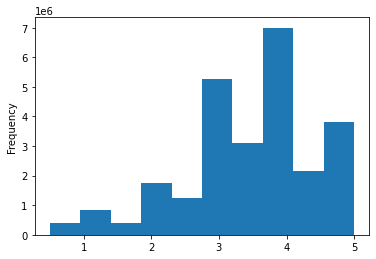

In [104]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()

In [106]:
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])

In [108]:
movies_df.head()

,url,year,imdb_link,title_wiki,Directed by,Produced by,Screenplay by,Story by,Based on,Starring,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
0,https://en.wikipedia.org/wiki/The_Adventures_o...,"1,990.00",https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,Renny Harlin,"[Steve Perry, Joel Silver]","[David Arnott, James Cappe, Daniel Waters]","[David Arnott, James Cappe]","[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",...,1990-07-11,"20,423,389.00",104.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Kojak. Columbo. Dirty Harry. Wimps.,The Adventures of Ford Fairlane,False,6.20,72.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...","1,990.00",https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet",James Foley,"[Ric Kidney, Robert Redlin]","[James Foley, Robert Redlin]",NaN,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",...,1990-08-24,0.00,114.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they risked was everything.,"After Dark, My Sweet",False,6.50,17.00
2,https://en.wikipedia.org/wiki/Air_America_(film),"1,990.00",https://www.imdb.com/title/tt0099005/,Air America,Roger Spottiswoode,Daniel Melnick,"[John Eskow, Richard Rush]",NaN,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",...,1990-08-10,"33,461,269.00",112.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The few. The proud. The totally insane.,Air America,False,5.30,146.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),"1,990.00",https://www.imdb.com/title/tt0099012/,Alice,Woody Allen,Robert Greenhut,NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",...,1990-12-25,0.00,102.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Alice,False,6.30,57.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,"1,990.00",https://www.imdb.com/title/tt0099018/,Almost an Angel,John Cornell,John Cornell,NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",...,1990-12-21,0.00,95.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Who does he think he is?,Almost an Angel,False,5.60,23.00


In [109]:
# Competing data:
# Wiki                     Movielens                Resolution
#--------------------------------------------------------------------------
# title_wiki               title_kaggle             drop wikipedia
# running_time             runtime                  keep Kaggle; fill in zeros with wikipedia data
# budget_wiki              budget_kaggle            keep Kaggle; fill in zeros with wikipedia data
# box_office               revenue                  keep Kaggle; fill in zeros with wikipedia data
# release_date_wiki        release_date_kaggle      drop wikipedia
# Language                 original_language        drop wikipedia
# Production company(s)    production_companies     drop wikipedia

In [113]:
# movies_df[['title_wiki','title_kaggle']]
# movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]
# Show any rows where title_kaggle is empty
# movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]

In [115]:
# movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')

In [117]:
# movies_df.fillna(0).plot(x='budget_wiki',y='budget_kaggle', kind='scatter')

In [120]:
# movies_df.fillna(0).plot(x='box_office', y='revenue', kind='scatter')
# movies_df.fillna(0)[movies_df['box_office'] < 10**9].plot(x='box_office', y='revenue', kind='scatter')

In [124]:
# movies_df[['release_date_wiki','release_date_kaggle']].plot(x='release_date_wiki', y='release_date_kaggle', style='.')
# movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')]
# movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index
movies_df = movies_df.drop(movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index)

In [126]:
# movies_df[movies_df['release_date_wiki'].isnull()]

In [129]:
# movies_df['Language'].apply(lambda x: tuple(x) if type(x) == list else x).value_counts(dropna=False)
# movies_df['original_language'].value_counts(dropna=False)

In [135]:
movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Productioncompanies ','Productioncompany '], inplace=True)

In [137]:
# sorted(movies_df.columns.tolist())

In [138]:
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column], axis=1)
    df.drop(columns=wiki_column, inplace=True)

In [141]:
fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
movies_df

,url,year,imdb_link,Directed by,Produced by,Screenplay by,Story by,Based on,Starring,Music by,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
0,https://en.wikipedia.org/wiki/The_Adventures_o...,"1,990.00",https://www.imdb.com/title/tt0098987/,Renny Harlin,"[Steve Perry, Joel Silver]","[David Arnott, James Cappe, Daniel Waters]","[David Arnott, James Cappe]","[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...","[Cliff Eidelman, Yello]",...,1990-07-11,"20,423,389.00",104.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Kojak. Columbo. Dirty Harry. Wimps.,The Adventures of Ford Fairlane,False,6.20,72.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...","1,990.00",https://www.imdb.com/title/tt0098994/,James Foley,"[Ric Kidney, Robert Redlin]","[James Foley, Robert Redlin]",NaN,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Maurice Jarre,...,1990-08-24,"2,700,000.00",114.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they risked was everything.,"After Dark, My Sweet",False,6.50,17.00
2,https://en.wikipedia.org/wiki/Air_America_(film),"1,990.00",https://www.imdb.com/title/tt0099005/,Roger Spottiswoode,Daniel Melnick,"[John Eskow, Richard Rush]",NaN,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Charles Gross,...,1990-08-10,"33,461,269.00",112.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The few. The proud. The totally insane.,Air America,False,5.30,146.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),"1,990.00",https://www.imdb.com/title/tt0099012/,Woody Allen,Robert Greenhut,NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",NaN,...,1990-12-25,"7,331,647.00",102.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Alice,False,6.30,57.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,"1,990.00",https://www.imdb.com/title/tt0099018/,John Cornell,John Cornell,NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Maurice Jarre,...,1990-12-21,"6,939,946.00",95.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Who does he think he is?,Almost an Angel,False,5.60,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,https://en.wikipedia.org/wiki/A_Fantastic_Woman,"2,018.00",https://www.imdb.com/title/tt5639354/,Sebastián Lelio,"[Juan de Dios Larraín, Pablo Larraín]",NaN,NaN,NaN,"[Daniela Vega, Francisco Reyes]",Matthew Herbert,...,2017-04-06,"3,700,000.00",104.00,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,A Fantastic Woman,False,7.20,13.00
6073,https://en.wikipedia.org/wiki/Permission_(film),"2,018.00",https://www.imdb.com/title/tt5390066/,Brian Crano,"[Brian Crano, Rebecca Hall]",NaN,NaN,NaN,"[Rebecca Hall, Dan Stevens, Morgan Spector, Fr...",NaN,...,2017-04-22,nan,96.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Permission,False,0.00,1.00
6074,https://en.wikipedia.org/wiki/Loveless_(film),"2,018.00",https://www.imdb.com/title/tt6304162/,Andrey Zvyagintsev,"[Alexander Rodnyansky, Sergey Melkumov, Gleb F...","[Oleg Negin, Andrey Zvyagintsev]",NaN,NaN,"[Maryana Spivak, Aleksey Rozin, Matvey Novikov...","[Evgueni Galperine, Sacha Galperine]",...,2017-06-01,"4,800,000.00",128.00,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Loveless,False,7.80,26.00
6075,https://en.wikipedia.org/wiki/Gemini_(2017_film),"2,018.00",https://www.imdb.com/title/tt5795086/,Aaron Katz,"[Mynette Louie, Sara Murphy, Adele Romanski]",NaN,NaN,NaN,"[Lola Kirke, Zoë Kravitz, Greta Lee, Michelle ...",Keegan DeWitt,...,2017-03-12,"200,340.00",92.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Post Production,NaN,Gemini,False,0.00,0.00


In [142]:
for col in movies_df.columns:
    lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
    value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
    num_values = len(value_counts)
    if num_values == 1:
        print(col)

video


In [145]:
# movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
#                        'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
#                        'genres','original_language','overview','spoken_languages','Country',
#                        'production_companies','production_countries','Distributor',
#                        'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
#                       ]]

In [146]:
movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

In [149]:
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')

In [150]:
rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]

In [151]:
movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')

In [152]:
movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)

In [153]:
movies_with_ratings_df.head()

,wikipedia_url,year,imdb_link,Directed by,Produced by,Screenplay by,Story by,based_on,starring,Music by,...,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
0,https://en.wikipedia.org/wiki/The_Adventures_o...,"1,990.00",https://www.imdb.com/title/tt0098987/,Renny Harlin,"[Steve Perry, Joel Silver]","[David Arnott, James Cappe, Daniel Waters]","[David Arnott, James Cappe]","[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...","[Cliff Eidelman, Yello]",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...","1,990.00",https://www.imdb.com/title/tt0098994/,James Foley,"[Ric Kidney, Robert Redlin]","[James Foley, Robert Redlin]",NaN,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Maurice Jarre,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,https://en.wikipedia.org/wiki/Air_America_(film),"1,990.00",https://www.imdb.com/title/tt0099005/,Roger Spottiswoode,Daniel Melnick,"[John Eskow, Richard Rush]",NaN,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Charles Gross,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),"1,990.00",https://www.imdb.com/title/tt0099012/,Woody Allen,Robert Greenhut,NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,"1,990.00",https://www.imdb.com/title/tt0099018/,John Cornell,John Cornell,NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Maurice Jarre,...,3.00,0.00,3.00,2.00,5.00,26.00,37.00,46.00,16.00,11.00
